<img src="https://www.nospamproxy.de/wp-content/uploads/Welche-Arten-von-Malware-gibt-es.png" alt="Drawing" style="width: 1000px;height: 400px"/>

<h1 align='center'> Malware Detection using Machine Learning </h1>


## What is a malware?

The term Malware is a combination of of two words - **Mal**icious Soft**ware**. To put it very simply, it is a piece of software written specifically with the intent of harming the victim, by direct or indirect ways. The Malware industry has grown manifold in the last few years. 

Which forced the anti-malware groups/communities to build more robust softwares to detect and terminate these attacks. The major part of protecting a computer system from a malware attack is to **identify whether a given piece of file/software** is a malware.

## Introducing the problem

<p>    Microsoft has been very active in building anti-malware products over the years  and it runs it’s anti-malware utilities over <b>150 million computers</b> around the world. This generates tens of millions of daily data points to be analyzed as potential malware. In order to be effective in analyzing and classifying such large amounts of data, we need to be able to group them into groups and identify their respective families. 
<br>
<br>
This dataset provided by Microsoft contains about 9 classes of malware.</p>

You can find the original problem statement and data posted on Kaggle  [here](https://www.kaggle.com/c/malware-classification).

## Real world constraints

1. Minimize multi-class error.
2. The model should return multi-class probability estimates.
3. Malware detection should not take hours and block the user's computer. It should fininsh in a few seconds or a minute.

Let's begin by importing the libraries we need

In [3]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import glob
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from multiprocessing import Process
import multiprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.layers import Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, log_loss
from keras.utils import to_categorical
from prettytable import PrettyTable

In [4]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Data 


<li> For every malware, we have two files <ol> <li> .asm file (read more: https://www.reviversoft.com/file-extensions/asm) </li><li>.bytes file (the raw data contains the hexadecimal representation of the file's binary content, without the PE header)</li></ol></li> 
    
<li>Total train dataset consist of about 180GB data out of which 47Gb of data is .bytes files and 137GB of data is .asm files.</li>

<li>There are 10,868 .bytes files and 10,868 asm files which makes it a total of 21,736 files. </li>

<li>There are 9 types of malwares (9 classes) in the data</li>
<li> Types of Malware:
    <ol>
        <li> Ramnit </li>
        <li> Lollipop </li>
        <li> Kelihos_ver3 </li>
        <li> Vundo </li>
        <li> Simda </li>
        <li> Tracur </li>
        <li> Kelihos_ver1 </li>
        <li> Obfuscator.ACY </li>
        <li> Gatak </li>
    </ol>
</li>


Let's start the analysis by looking at the data files.

**Example of Bytefiles**

In [27]:
f = open('./bytefiles/folder_0/CnO9AljfBmokT5qN7J6S.bytes')
c=0
for line in f:
    if c < 20:
        print(line, end='')
        c+=1
    else:
        break
        
f.close()

00401000 48 70 63 00 5A 83 C4 24 5D C3 00 00 8B FF 55 8B
00401010 EC 83 EC 54 03 45 DC BB 7C 81 63 00 BF AC 06 00
00401020 00 57 BA AC 06 00 00 52 68 01 00 04 00 B8 7A D5
00401030 3F 86 FF B0 86 9A 23 7A 83 2C 24 02 B8 38 70 63
00401040 00 8F 00 3E FF 15 38 70 63 00 50 8F 83 BC FE FF
00401050 FF 8B BB BC FE FF FF 8B C7 2B FF 4F 81 E7 20 5D
00401060 63 00 BA 73 5A E4 9D 68 AC 06 00 00 59 33 F6 FF
00401070 34 37 FF 04 24 31 14 24 8F 04 70 FF 37 5A 83 C7
00401080 04 83 C0 04 83 E9 04 83 F9 00 75 E1 BF 00 00 00
00401090 00 57 3E FF 15 30 70 63 00 83 C4 54 5D C3 00 00
004010A0 00 00 00 00 8B FF 55 8B EC 83 EC 3C 8D 91 C0 00
004010B0 00 00 0B 5D E8 52 6A 00 3E FF 15 18 70 63 00 5A
004010C0 52 53 50 FF 72 0C E8 05 F4 FF FF 83 C4 0C 5A 52
004010D0 BB 00 00 00 00 53 3E FF 15 64 70 63 00 5A 83 C4
004010E0 3C 5D C3 00 2E C9 86 C7 9A D0 34 15 9A 65 F3 E9
004010F0 66 68 D3 40 35 6B FB C1 22 23 B9 BC 2A 91 AB BF
00401100 C3 43 C5 BC 3F 71 76 B2 49 85 AD AB B0 E6 27 0B
00401110 F5 77 A5 04 AA 94 6A 3

**Example of asm files**

In [28]:
f = open('./asmfiles/CnO9AljfBmokT5qN7J6S.asm')
c=0
for line in f:
    if c < 50:
        print(line, end='')
        c+=1
    else:
        break
        
f.close()

HEADER:00400000							;
HEADER:00400000							; +-------------------------------------------------------------------------+
HEADER:00400000							; |   This file	has been generated by The Interactive Disassembler (IDA)    |
HEADER:00400000							; |	      Copyright	(c) 2013 Hex-Rays, <support@hex-rays.com>	    |
HEADER:00400000							; |			 License info:                			    |
HEADER:00400000							; |				   Microsoft				    |
HEADER:00400000							; +-------------------------------------------------------------------------+
HEADER:00400000							;
HEADER:00400000
HEADER:00400000
HEADER:00400000									.686p
HEADER:00400000									.mmx
HEADER:00400000									.model flat
HEADER:00400000
HEADER:00400000							; ===========================================================================
HEADER:00400000
HEADER:00400000							; [00235000 BYTES: COLLAPSED SEGMENT HEADER. PRESS KEYPAD CTRL-"+" TO EXPAND]
.text:00635000						       ; 
.text:00635000						       ; Format	     : Portable	exe

The size of the total dataset available on Kaggle is huge. Since I don't have the compute power needed to process it all, I'll be using just the `train.7z` file, which is the training data containing ~10K distinct .byte and .asm files. I have unzipped the original compressed file on the disk. Let's verify the number of files in the data.

In [4]:
# Total number of .byte files
len(glob.glob('*.bytes'))

10868

**Total size of .byte and .asm files**

In [85]:
print('Total size of .byte files: {} GB'.format(
    np.round(df_trainLabels.size_in_MB_bytefile.sum() / 1024.0), 2))
print('Total size of .asm files: {} GB'.format(
    np.round(df_trainLabels.size_in_MB_asmfile.sum() / 1024.0), 2))

Total size of .byte files: 47.0 GB
Total size of .asm files: 137.0 GB


As you can notice above, the total size of this data is 184 GB! Let's separate the bytefiles and asm files into different folders so that they become easy to process.

In [ ]:
!mv train/*.bytes bytefiles/

In [5]:
!mv train/*.asm asmfiles/

## Distribution of malware classes in the whole dataset

This is a multiclass dataset. Let's see how the various classes are distributed. Is it imbalanced?

In [3]:
df_trainLabels = pd.read_csv('trainLabels.csv')

The trainLabels file has an `Id` which is the name of the file and `Class` to which it belongs

In [4]:
df_trainLabels.head()

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


Class 3 has the highest proportion while class 5 the lowest.

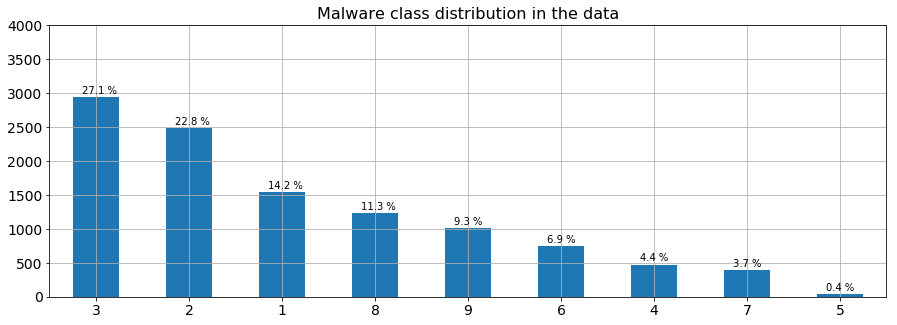

In [12]:
plt.figure(figsize=(15,5))

ax = df_trainLabels.Class.value_counts().plot.bar(rot=0)
total_data_points = df_trainLabels['Class'].count()

for p in ax.patches:
    ax.annotate('{:.1f} %'.format((p.get_height() / total_data_points) * 100),
                (p.get_x() + 0.1, p.get_height() + 50))

plt.ylim([0, 4000])

plt.title('Malware class distribution in the data', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid()
plt.show()

Let's create another column in this table called `bytefile_corpus`. This will be used for mapping the cleaned text data from .byte files to its `Id`. The reason behind doing this is that it will make it easier to get the `Bag of Words` representation of the data.

In [6]:
df_trainLabels['bytefile_corpus'] = df_trainLabels['Id']

In [7]:
df_trainLabels.head()

,Id,Class,bytefile_corpus
0,01kcPWA9K2BOxQeS5Rju,1,01kcPWA9K2BOxQeS5Rju
1,04EjIdbPV5e1XroFOpiN,1,04EjIdbPV5e1XroFOpiN
2,05EeG39MTRrI6VY21DPd,1,05EeG39MTRrI6VY21DPd
3,05rJTUWYAKNegBk2wE8X,1,05rJTUWYAKNegBk2wE8X
4,0AnoOZDNbPXIr2MRBSCJ,1,0AnoOZDNbPXIr2MRBSCJ


## New feature: Bytefiles size

Can we know anything about the class of the malware from its file size? The following block of code calculates the size of the files on disk and stores it against its ID.

In [13]:
# Dictionary that stores the mapping of File Id to its size in MB
dict_bytefile_size = {}

# Travel through the bytefiles directory and generate the file to size mapping
for file in glob.glob('**/*.bytes', recursive=True):
    dict_bytefile_size[os.path.basename(file).split('.')[0]] = np.round(
        (os.stat(file).st_size / (1024 * 1024)), 2)

Add another column to the above dataframe that stores the bytefile size for a given Id

In [14]:
df_trainLabels['size_in_MB_bytefile'] = df_trainLabels['Id']
df_trainLabels['size_in_MB_bytefile'] = df_trainLabels['size_in_MB_bytefile'].map(dict_bytefile_size)

In [26]:
df_trainLabels['Class']=df_trainLabels['Class'].astype('category')

## Is the byte file size feature useful?

There's some clear pattern between the file sizes of different types of malware. e.g. notice the box plots of classes 2 and 4

Text(0, 0.5, 'Size in MB')

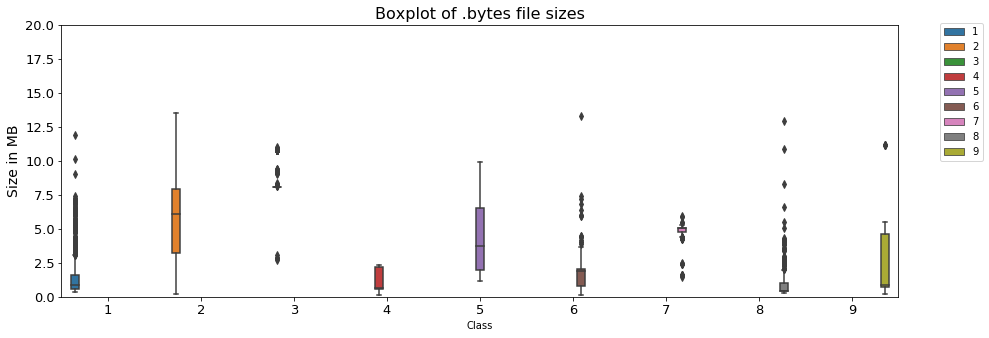

In [48]:
plt.figure(figsize=(15,5))
sbn.boxplot(x='Class',y='size_in_MB_bytefile', hue='Class', data= df_trainLabels)
plt.ylim([0,20])
plt.legend(loc=(1.05,0.5))
plt.title('Boxplot of .bytes file sizes', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Size in MB', fontsize=14)

### Avg bytefile size per class

Mean, median, max, min and Standard Deviation for filesizes of various classes

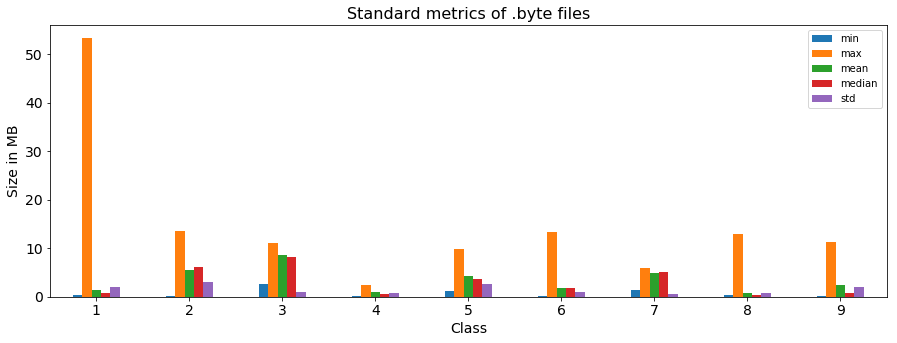

In [53]:
df_trainLabels.groupby('Class')['size_in_MB_bytefile'].agg(
    ['min','max', 'mean', 'median', 'std']).plot.bar(figsize=(15, 5), rot=0)
plt.title('Standard metrics of .byte files', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Size in MB', fontsize=14)
plt.show()

## New feature: .asm file size

Can the .asm file size provide any useful insight about the class of the malware? Similar to how we calculated the bytefile size, let's calculate the sizes of the .asm files on the disk.

In [59]:
dict_asmfile_size = {}

# Store a mapping of Bytefile name to file size in MB
for file in glob.glob('asmfiles/*.asm', recursive=True):
    dict_asmfile_size[os.path.basename(file).split('.')[0]] = np.round(
        (os.stat(file).st_size / (1024 * 1024)), 2)

In [61]:
len(dict_asmfile_size.keys())

10868

In [63]:
df_trainLabels['size_in_MB_asmfile'] = df_trainLabels['Id']
df_trainLabels['size_in_MB_asmfile'] = df_trainLabels['size_in_MB_asmfile'].map(dict_asmfile_size)

## Is the .asm file size any useful?

Text(0, 0.5, 'Size in MB')

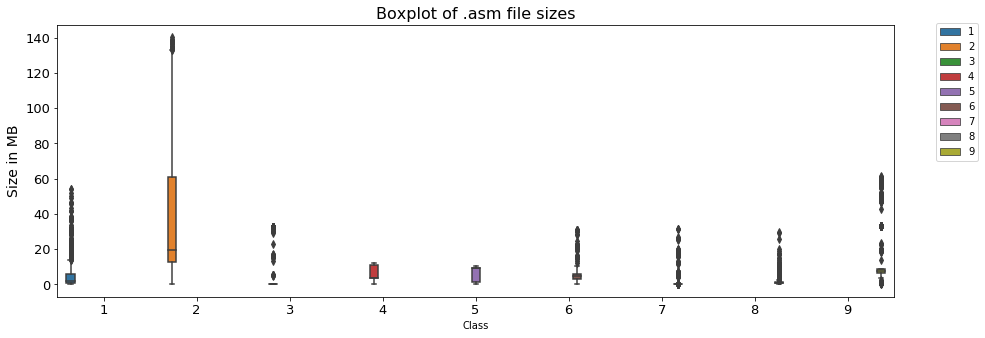

In [64]:
plt.figure(figsize=(15,5))
sbn.boxplot(x='Class',y='size_in_MB_asmfile', hue='Class', data= df_trainLabels)
#plt.ylim([0,20])
plt.legend(loc=(1.05,0.5))
plt.title('Boxplot of .asm file sizes', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Size in MB', fontsize=14)

### Avg .asm file sizes per class

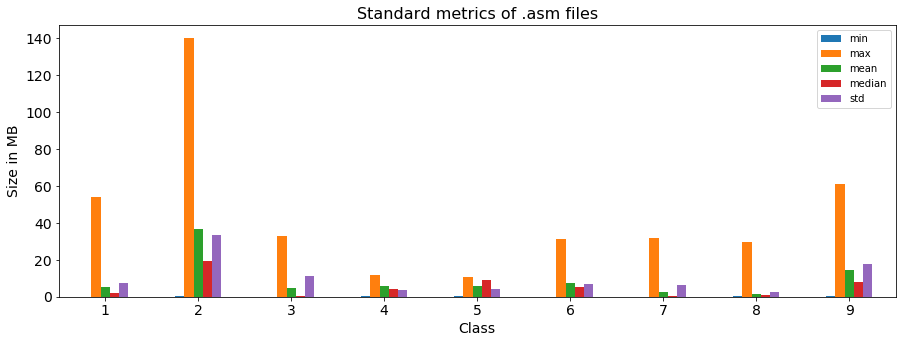

In [65]:
df_trainLabels.groupby('Class')['size_in_MB_asmfile'].agg(
    ['min','max', 'mean', 'median', 'std']).plot.bar(figsize=(15, 5), rot=0)
plt.title('Standard metrics of .asm files', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Size in MB', fontsize=14)
plt.show()

## Comparing both file sizes together

Observe in the graph below that only for classes 3 and 7, the mean file size of .byte files is more than the corresponding .asm file size.

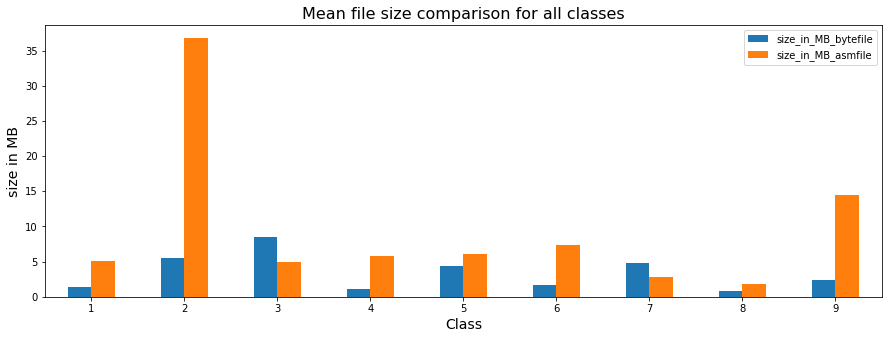

In [75]:
df_trainLabels.groupby(
    'Class')['size_in_MB_bytefile', 'size_in_MB_asmfile'].mean().plot.bar(
        rot=0, figsize=(15, 5))
plt.title('Mean file size comparison for all classes', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('size in MB', fontsize=14)
plt.show()

**Extract text from .byte files**

Let's store the file names in a list. This will help in processing them later.

In [78]:
file_name_keys = []

for f in glob.glob('*.bytes'):
    file_name_keys.append(f.split('.')[0])

## Multiprocessing to extract text from byte files

Let's move `.byte` files into 10 separate folders and parallely process them. Each process will work on files in one folder to extract the text from the files in that folder.

In [19]:
# Dictionary to store the mapping of file name to the folder to which it is to be moved
file_to_folder_mapping  = {}

# Run through the files in the byte files folder and assign it to a folder name
for ix, f in enumerate(glob.glob('*.bytes')):
     
    folder_name = 'folder_{}'.format(ix % 10)
    file_to_folder_mapping[f] = folder_name    

Create 10 different folders on the disk

In [17]:
for folder in [
        'folder_0', 'folder_1', 'folder_2', 'folder_3', 'folder_4', 'folder_5',
        'folder_6', 'folder_7', 'folder_8', 'folder_9'
]:
    os.mkdir(folder)

Move the files to one of the 10 folders according to the mapping we defined above

In [ ]:
%notify

for file_name,folder_name in file_to_folder_mapping.items():
    shutil.move(file_name, folder_name)

Number of files in each folder

In [20]:
pd.Series(list(file_to_folder_mapping.values())).value_counts()

folder_5    1087
folder_3    1087
folder_1    1087
folder_7    1087
folder_2    1087
folder_4    1087
folder_0    1087
folder_6    1087
folder_9    1086
folder_8    1086
dtype: int64

## Function to extract text from .byte files

In [8]:
%%notify

def bow_corpus(folder_path, return_dict):
    
    count = 0

    #for file in os.listdir('dataSample/'):
    #dict_file_To_bowCorpus = {}

    for filepath in glob.glob(folder_path + '/*.bytes'):

        # file = os.path.basename(filepath)
        
        with open(filepath, 'r', encoding='iso-8859-15') as fh:

            words_in_file = []

            for line in fh.readlines():
                words_in_file += list(map(str.strip,line.split(' ')[1:]))

            # Map the filename key to the text corpus in that file
            return_dict[os.path.basename(filepath).split('.')[0]] = ' '.join(words_in_file)

        print(count, end='\r')
        count += 1
        # print(' '.join(list(map(str.strip,line.split(' ')[1:]))))
    #        print(fh.readline())
    
    return return_dict

<IPython.core.display.Javascript object>

### Main driver program that coordinates the multiprocessing code

In [10]:
def main():
    
    manager = multiprocessing.Manager()
    
    return_dict = manager.dict()
    
    p0=Process(target=bow_corpus, args=('folder_0',return_dict))
    p1=Process(target=bow_corpus, args=('folder_1', return_dict))
    p2=Process(target=bow_corpus, args=('folder_2', return_dict))
    p3=Process(target=bow_corpus, args=('folder_3', return_dict))
    p4=Process(target=bow_corpus, args=('folder_4', return_dict))
    p5=Process(target=bow_corpus, args=('folder_5',return_dict))
    p6=Process(target=bow_corpus, args=('folder_6', return_dict))
    p7=Process(target=bow_corpus, args=('folder_7', return_dict))
    p8=Process(target=bow_corpus, args=('folder_8', return_dict))
    p9=Process(target=bow_corpus, args=('folder_9', return_dict))
    
    p0.start()
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    p9.start()

    p0.join()
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()

    return dict(return_dict)
    
if __name__ == '__main__':
    dict_file_to_bow_Corpus = main()

The datatype of the returned object by the above code is `dict`. It contains a mapping between file ID and a string containing the text in the bytefile.

As expected, there are 10868 keys in this dictionary

In [14]:
len(dict_file_to_bow_Corpus.keys())

10868

Recall that in the dataframe `df_trainLabels` we had added a column called `bytefile_corpus`. Let's use that to map the text from bytefiles to their Id.

In [15]:
df_trainLabels.head()

,Id,Class,bytefile_corpus
0,01kcPWA9K2BOxQeS5Rju,1,01kcPWA9K2BOxQeS5Rju
1,04EjIdbPV5e1XroFOpiN,1,04EjIdbPV5e1XroFOpiN
2,05EeG39MTRrI6VY21DPd,1,05EeG39MTRrI6VY21DPd
3,05rJTUWYAKNegBk2wE8X,1,05rJTUWYAKNegBk2wE8X
4,0AnoOZDNbPXIr2MRBSCJ,1,0AnoOZDNbPXIr2MRBSCJ


Replace the `bytefile_corpus` column in the above dataframe with the text corpus in the corresponding file

In [16]:
df_trainLabels.bytefile_corpus = df_trainLabels.bytefile_corpus.map(dict_file_to_bow_Corpus)

### This is how the modified dataframe looks

The bytefile_corpus column contains the features extracted from the file.

Each cell in the column `bytefile_corpus` contains useful text in the corresponding .byte file.

In [24]:
df_trainLabels.head()

,Id,Class,bytefile_corpus
0,01kcPWA9K2BOxQeS5Rju,1,6A FF 68 A3 16 00 10 64 A1 00 00 00 00 50 64 8...
1,04EjIdbPV5e1XroFOpiN,1,?? ?? ?? ?? 00 00 00 00 ?? ?? ?? ?? ?? ?? ?? ?...
2,05EeG39MTRrI6VY21DPd,1,56 8B F1 8B 46 04 85 C0 C7 06 A4 61 00 10 74 0...
3,05rJTUWYAKNegBk2wE8X,1,4D 5A 90 00 03 00 00 00 04 00 00 00 FF FF 00 0...
4,0AnoOZDNbPXIr2MRBSCJ,1,FF 25 F8 80 00 10 FF 25 F4 80 00 10 FF 25 D8 8...


This is a humongous dataframe. For demonstration, see the text in the 49th file. It has 3.4 Million characters!

In [23]:
len(df_trainLabels.bytefile_corpus[49])

3416063

Save this to the disk, to avoid processing the whole thing again.

In [29]:
df_trainLabels.to_csv('../df_bytefiles_textCorpus.csv', index=False)

Pickle the dictionary mapping of ID to corpus to a file

In [13]:
f = open('dict_bytefile_To_bowCorpus.pkl', 'wb')
pickle.dump(dict_file_To_bowCorpus, f)
f.close()

## Bag Of Words representation of byte files

The following block of code converts the bytefiles text into its BOW representation.

In [ ]:
%notify

vec = CountVectorizer()

bow_byte_transformed = vec.fit_transform(df_trainLabels.bytefile_corpus)

The transformed file is a vector of shape `number_of_files * 256 `

In [32]:
bow_byte_transformed.shape

(10868, 256)

Feature names obtained from the BoW representation. As expected, they are `00` to `ff`

In [35]:
np.unique(vec.get_feature_names())

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0a',
       '0b', '0c', '0d', '0e', '0f', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '1a', '1b', '1c', '1d', '1e', '1f', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '2a', '2b',
       '2c', '2d', '2e', '2f', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '3a', '3b', '3c', '3d', '3e', '3f', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '4a', '4b', '4c',
       '4d', '4e', '4f', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59', '5a', '5b', '5c', '5d', '5e', '5f', '60', '61', '62',
       '63', '64', '65', '66', '67', '68', '69', '6a', '6b', '6c', '6d',
       '6e', '6f', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '7a', '7b', '7c', '7d', '7e', '7f', '80', '81', '82', '83',
       '84', '85', '86', '87', '88', '89', '8a', '8b', '8c', '8d', '8e',
       '8f', '90', '91', '92', '93', '94', '95', '9

In [37]:
len(np.unique(vec.get_feature_names()))

256

## Create a dataframe of the transformed BoW representation array, file ID and class labels

In [42]:
df_bytesfiles_bow = pd.DataFrame(np.hstack([
    pd.DataFrame(bow_byte_transformed.toarray()),
    df_trainLabels['Class'].values.reshape(-1, 1), df_trainLabels['Id'].values.reshape(-1,1)
]),
                                 columns=vec.get_feature_names() + ['class', 'Id'])

Let's do a sanity check by making sure that the class distribution is still the same and nothing weird has happened while processing the data

Text(0.5, 1.0, 'Distribution of classes')

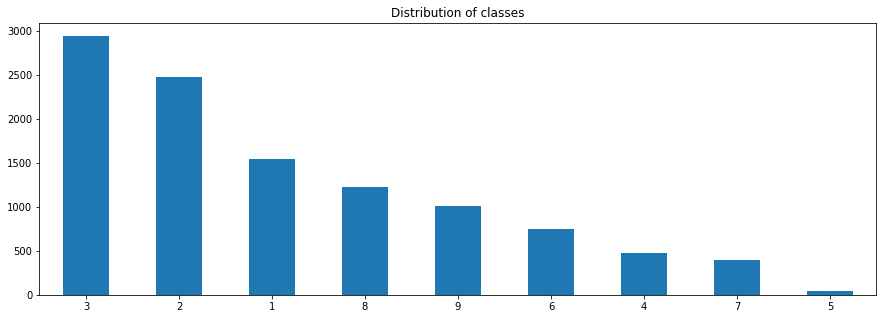

In [45]:
df_bytesfiles_bow['class'].value_counts().plot.bar(rot=0, figsize=(15,5))
plt.title('Distribution of classes')

Save the file to the disk

In [ ]:
%%notify
df_bytesfiles_bow.to_csv('../df_bytesfiles_bow.csv', index=False)

This is how the dataframe looks, where columns 00 to ff are the BoW representations of the files. Additionally, it contains the columns class and Id.

In [47]:
df_bytesfiles_bow

,00,01,02,03,04,05,06,07,08,09,...,f8,f9,fa,fb,fc,fd,fe,ff,class,Id
0,21091,1213,726,817,1257,625,550,523,1078,473,...,873,485,462,516,1133,471,761,7998,1,01kcPWA9K2BOxQeS5Rju
1,40030,1980,1226,1193,1971,1096,961,755,2406,550,...,806,479,357,394,1114,507,1080,10826,1,04EjIdbPV5e1XroFOpiN
2,19419,955,693,656,832,463,370,510,836,449,...,463,354,472,393,384,303,390,2104,1,05EeG39MTRrI6VY21DPd
3,79568,6445,3143,2517,4982,1824,2125,2964,8301,1530,...,4012,1511,1604,2407,5196,4614,4448,47484,1,05rJTUWYAKNegBk2wE8X
4,25791,1202,569,750,948,456,405,517,754,494,...,500,316,297,343,452,283,401,4532,1,0AnoOZDNbPXIr2MRBSCJ
5,22528,1344,796,747,1443,819,738,627,1715,572,...,878,481,486,536,947,541,778,4580,1,0AwWs42SUQ19mI7eDcTC
6,17605,843,545,639,905,379,370,406,629,415,...,374,338,327,332,374,336,380,2203,1,0cH8YeO15ZywEhPrJvmj
7,46625,3758,1071,1195,1379,727,688,797,1905,688,...,1094,409,363,687,1429,429,1172,10762,1,0DNVFKwYlcjO7bTfJ5p1
8,33240,2993,1085,1081,1401,692,547,677,1304,590,...,739,507,559,475,645,386,572,4588,1,0DqUX5rkg3IbMY6BLGCE
9,69310,6564,3794,5962,6843,3839,6429,2346,4494,1249,...,1705,1100,1079,1116,1329,1857,1965,8013,1,0eaNKwluUmkYdIvZ923c


Loading the file after restarting the session

In [5]:
df_bytefile_bow = pd.read_csv('df_bytesfiles_bow.csv')

**Let's add the `file size` feature to this dataframe**

In [59]:
df_bytesfiles_bow['byte_file_size'] = df_bytesfiles_bow['Id']
df_bytesfiles_bow['byte_file_size'] = df_bytesfiles_bow['byte_file_size'].map(dict_bytefile_size)

Save the final dataframe on disk. Thus, in the end, the data is finally in a format that can be used for training machine learning models:

      Bag of Words [10868 x 256]
    + Size of byte file [10868 x 1]
    --------------------------------
    = [10868 x 257]
    

save it to the disk

In [67]:
df_bytesfiles_bow.to_csv('../df_bytesfiles_bow.csv', index=False)

# TSNE visualization of Bag of Words features

t-Distributed stochastic neighborhood embedding is a technique for visualizing high dimensional data into lower dimensions. Let's transform the BoW data using t-SNE to see if it can meaningfully separate the malware files into distinct classes.

In [4]:
df_bytefile_bow = pd.read_csv('df_bytesfiles_bow.csv')

In [95]:
df_bytefile_bow.head()

,00,01,02,03,04,05,06,07,08,09,...,f9,fa,fb,fc,fd,fe,ff,class,Id,byte_file_size
0,21091,1213,726,817,1257,625,550,523,1078,473,...,485,462,516,1133,471,761,7998,1,01kcPWA9K2BOxQeS5Rju,0.68
1,40030,1980,1226,1193,1971,1096,961,755,2406,550,...,479,357,394,1114,507,1080,10826,1,04EjIdbPV5e1XroFOpiN,0.85
2,19419,955,693,656,832,463,370,510,836,449,...,354,472,393,384,303,390,2104,1,05EeG39MTRrI6VY21DPd,0.51
3,79568,6445,3143,2517,4982,1824,2125,2964,8301,1530,...,1511,1604,2407,5196,4614,4448,47484,1,05rJTUWYAKNegBk2wE8X,2.79
4,25791,1202,569,750,948,456,405,517,754,494,...,316,297,343,452,283,401,4532,1,0AnoOZDNbPXIr2MRBSCJ,0.57


**Standardize data before using t-SNE**

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(df_bytefile_bow.drop(['Id', 'class'], axis=1))

## t-SNE with perplexity 30

The observations are exciting. You can observe several well separated clusters

In [104]:
tsne = TSNE(perplexity=30)
tsne_fit = tsne.fit_transform(X)

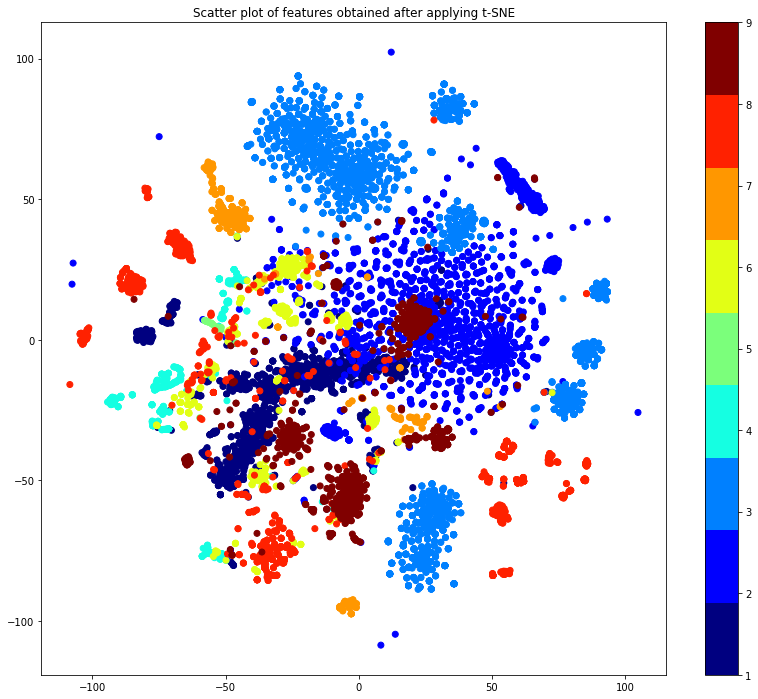

In [107]:
plt.figure(figsize=(14,12))

plt.scatter(tsne_fit[:,0], tsne_fit[:, 1], c = df_bytefile_bow['class'], cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar()
plt.title('Scatter plot of features obtained after applying t-SNE')
plt.show()

## t-SNE for perplexity 40

In [7]:
tsne = TSNE(perplexity=40)
tsne_fit = tsne.fit_transform(X)

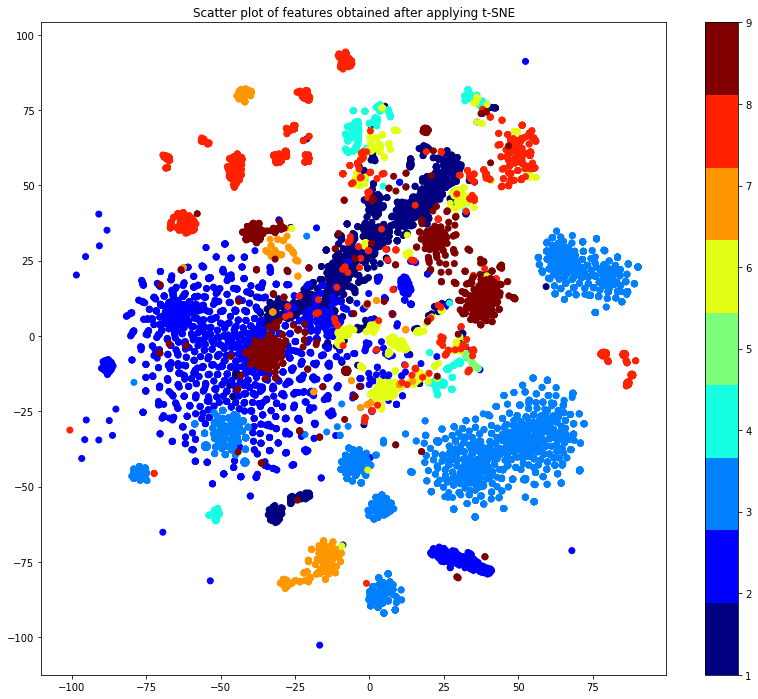

In [8]:
plt.figure(figsize=(14,12))

plt.scatter(tsne_fit[:,0], tsne_fit[:, 1], c = df_bytefile_bow['class'], cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar()
plt.title('Scatter plot of features obtained after applying t-SNE')
plt.show()

# Machine learning: only bytefile features

All right! the data preprocessing is complete. Now it's time to train our first ML model. Let's start simple. We'll first use only the bytefile features and see how the models perform. Later, we will combine the features obtained from both the `bytefiles` and the `asmfiles` for training.

It is necessary that we divide the data into train, test and CV sets. Doing this will allow us to carefully tune the hypeparameters and avoid overfitting.

In [35]:
# Train, test and CV sets
X_train_cv, X_test, y_train_cv, y_test = train_test_split(
    df_bytefile_bow.drop(['Id', 'class'], axis=1),
    df_bytefile_bow['class'],
    test_size=.2)

There are 8694 data points in the train+CV set

In [36]:
X_train_cv.shape, y_train_cv.shape

((8694, 257), (8694,))

while the test data contains 2174 data points

In [37]:
X_test.shape, y_test.shape

((2174, 257), (2174,))

Let's make sure that the train+CV and test data sets have the same distribution. i.e. they have similar representation of various classes.

The ML models will not perform well if the distribution of train data is different than that of test data.

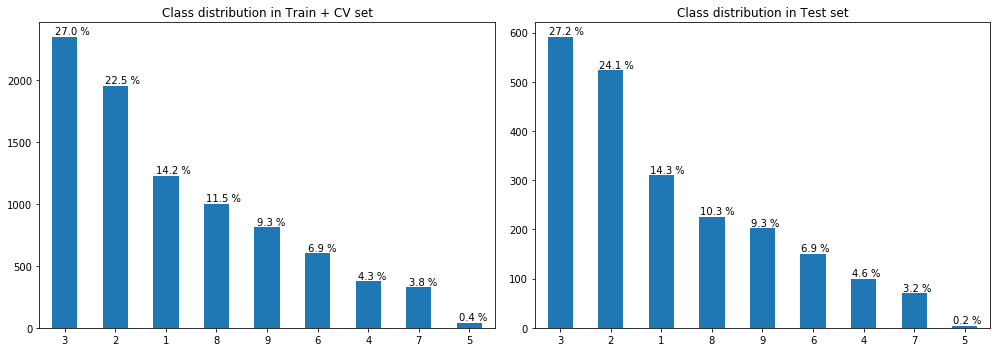

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = pd.Series(y_train_cv).value_counts().plot.bar(rot=0)
plt.title('Class distribution in Train + CV set')
total_data_points = y_train_cv.shape[0]
for p in ax.patches:
    ax.annotate('{:.1f} %'.format((p.get_height() / total_data_points) * 100),
                (p.get_x() + 0.05, p.get_height() + 20))


plt.subplot(1,2,2)
ax = pd.Series(y_test).value_counts().plot.bar(rot=0)
total_data_points = y_test.shape[0]
for p in ax.patches:
    ax.annotate('{:.1f} %'.format((p.get_height() / total_data_points) * 100),
                (p.get_x() + 0.02, p.get_height() + 5))

plt.tight_layout()
plt.title('Class distribution in Test set')
plt.show()

## Standardize data

The standardization operation rescales the data to have 0 mean and unit variance.

In [38]:
scaler = StandardScaler()
scaler.fit(X_train_cv)

X_train_cv = scaler.transform(X_train_cv)
X_test = scaler.transform(X_test)

## Function to plot confusion matrix

This function will help us better gauge the performance of the model by looking at the

* True Positives (TP)
* False Positives (FP)
* True Negatives (TN)
* False Negatives (FN)

In [17]:
def plot_confusion_matrix(actual_y, predict_y):
    
    C = confusion_matrix(actual_y, predict_y)
    print("Number of misclassified points ",(len(actual_y)-np.trace(C))/len(actual_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sbn.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sbn.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sbn.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sbn.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

## Model 0: Random Model for benchmarking

This model essentially makes a random guess about the class of the malware. It doesn't use any sophisticated ML technique.

It obviously cannot be used for predicting the actual labels of the malwares. Its purpose is just to serve as a benchmark for comparing the real ML models we'll build later. We always expect the real models to perform better than the random model. If they don't, we will know that something is not right. 

Log loss on Cross Validation Data using Random Model 2.476366204582465
Log loss on Test Data using Random Model 2.50854590434592
Number of misclassified points  89.65041398344066
-------------------------------------------------- Confusion matrix --------------------------------------------------


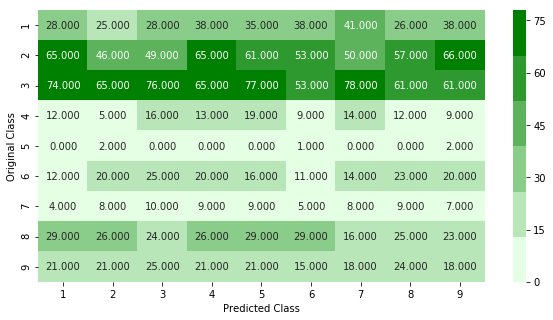

-------------------------------------------------- Precision matrix --------------------------------------------------


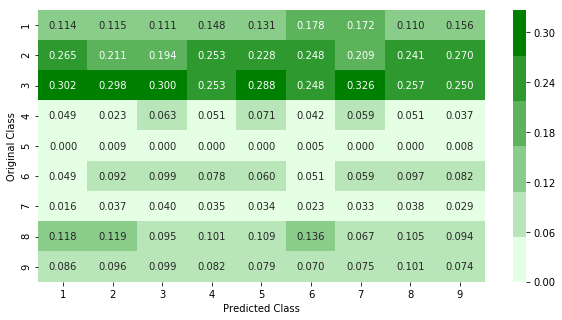

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


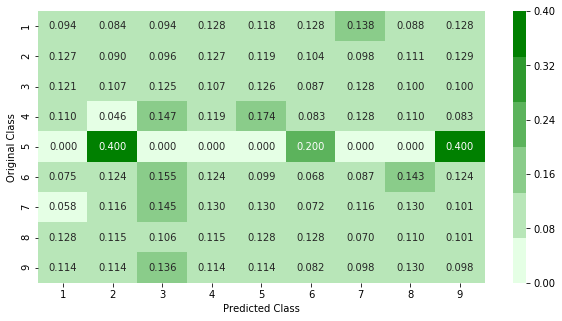

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
train_cv_data_len = X_train_cv.shape[0]

# we create a output array that has exactly same size as the CV data
train_cv_predicted_y = np.zeros((train_cv_data_len,9))
for i in range(train_cv_data_len):
    rand_probs = np.random.rand(1,9)
    train_cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Cross Validation Data using Random Model",log_loss(y_train_cv,train_cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

As you can observe above, the `logloss` for the random model is ~2.5. Which is not great. This is expected since our "model" is doing nothing but a random prediction for each data point. If we get a logloss more than 2.5, that'll be a red signal indicating something's horribly wrong with the ML model. 

Let's store the model parameters and logloss in a table for later reference.

In [24]:
table = PrettyTable()
table.field_names = ['#', 'ML algorithm', 'Features', '#Features','Log Loss (train/cv)','Log Loss (test)']
model_number = 1
table.add_row([model_number, 'Random Guess', 'bytefiles', '257', '2.48','2.50'])
model_number += 1

In [25]:
print(table)

+---+--------------+-----------+-----------+---------------------+-----------------+
| # | ML algorithm |  Features | #Features | Log Loss (train/cv) | Log Loss (test) |
+---+--------------+-----------+-----------+---------------------+-----------------+
| 1 | Random Guess | bytefiles |    257    |         2.48        |       2.50      |
+---+--------------+-----------+-----------+---------------------+-----------------+


## Model 1: Logistic Regression (only bytefile features)

In [5]:
df_bytesfiles_bow.shape

(10868, 259)

We will do a grid search with 5 fold cross validation to choose the optimal hyperparameters.

Since we are doing multiclass classification in which distribution of classes is not uniform, accuracy will not be the most appropriate metric in this case. Therefore, we will look at `neg_log_loss` which is just log loss with a negative sign.

In [11]:
lr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto')

parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf_gridsrch = GridSearchCV(lr,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=False,
                            cv=5,
                           scoring='neg_log_loss',
                           )

In [ ]:
clf_gridsrch.fit(X_train_cv,y_train_cv)

In [16]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)

The best parameters were {'C': 0.1}
The best score during Training/CV was -0.597309691239804


In [17]:
clf_gridsrch.score(X_test, y_test)

-0.6667510746083349

In [26]:
table.add_row([model_number, 'Logistic Regression', 'bytefiles', '257', '0.59','0.67'])
model_number+=1

## Model 2: Random Forests (only bytefile features)

In [28]:
rf = RandomForestClassifier()

parameters_dict = {'n_estimators': [5, 10], 'max_depth' : [4,5]}

clf_gridsrch = GridSearchCV(rf,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=False,
                            cv=5,
                           scoring='neg_log_loss',
                           )

In [29]:
clf_gridsrch.fit(X_train_cv,y_train_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [39]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'max_depth': 5, 'n_estimators': 10}
The best score during Training/CV was -0.45512553776331355
The score on Test data was -0.4252448496015287


In [27]:
table.add_row([model_number, 'Random Forest Classifier', 'bytefiles', '257', '0.45','0.42'])
model_number+=1

## Model 3: Gradient Boosting Classifier (only bytefile features)

In [41]:
gbc = GradientBoostingClassifier()

parameters_dict = {'learning_rate': [0.05,0.1, 0.2, 0.3],
                  'n_estimators':[100,150]}

clf_gridsrch = GridSearchCV(gbc,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=0,
                            cv=5,
                           scoring='neg_log_loss')

In [42]:
%%notify

clf_gridsrch.fit(X_train_cv, y_train_cv)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

<IPython.core.display.Javascript object>

In [43]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'learning_rate': 0.1, 'n_estimators': 150}
The best score during Training/CV was -0.07491459093371022
The score on Test data was -0.06333041101961978


In [28]:
table.add_row([model_number, 'Gradient Boosting Classifier', 'bytefiles', '257', '0.07','0.06'])
model_number+=1

Number of misclassified points  1.8859245630174795
-------------------------------------------------- Confusion matrix --------------------------------------------------


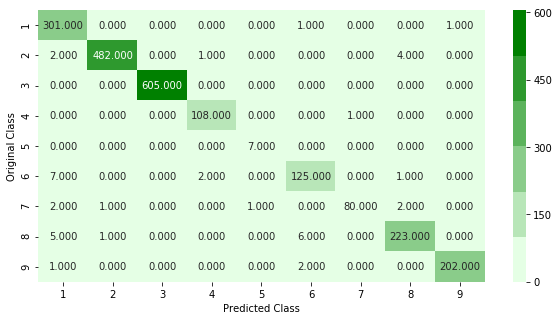

-------------------------------------------------- Precision matrix --------------------------------------------------


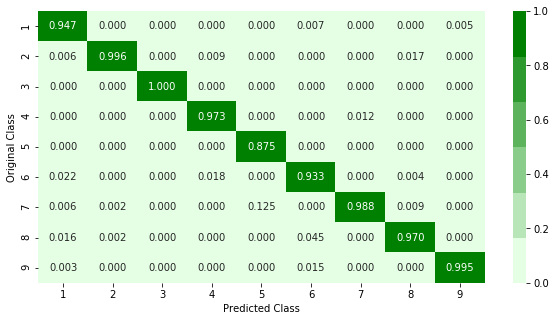

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


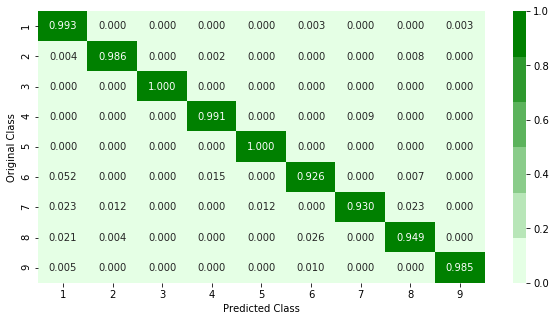

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [44]:
plot_confusion_matrix(y_test, clf_gridsrch.predict(X_test))

# Features extracted from .asm files


I'm using the preprocessed .asm file provided by AAIC. The reason for doing so is that it takes a long time to do it.

In [6]:
df_asmfiles = pd.read_csv('asmoutputfile.csv')

In [46]:
df_asmfiles.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,137,18,66,15,43,83,0,17,48,29
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,130,18,29,48,82,12,0,14,0,20
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,84,13,42,10,67,14,0,11,0,9
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,25,6,8,14,7,2,0,8,0,6
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,18,12,9,18,29,5,0,11,0,11


## Combining the asmfile features with the bytefiles features

We will now use features obtained from both types of files. We expect the performance of the model to go up by doing so, as more the number of features, more is the predictive power of a model

The resultant data set has 308 dimensions.

In [7]:
df_XY = pd.merge(df_asmfiles, df_bytefile_bow, left_on= 'ID', right_on='Id')

In [48]:
df_XY.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,f9,fa,fb,fc,fd,fe,ff,class,Id,byte_file_size
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,485,462,516,1133,471,761,7998,1,01kcPWA9K2BOxQeS5Rju,0.68
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,289,238,285,348,284,346,3071,1,1E93CpP60RHFNiT5Qfvn,0.40
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,273,268,841,369,286,551,3342,1,3ekVow2ajZHbTnBcsDfX,0.41
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,288,236,284,335,263,318,2917,1,3X2nY7iQaPBIWDrAZqJe,0.40
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,296,260,251,392,270,345,2979,1,46OZzdsSKDCFV8h7XWxf,0.40


## Visualize the combined asmfile and bytefiles (1gram) features using TSNE

In [20]:
tsne = TSNE(perplexity=30)

tsne_fit = tsne.fit_transform(df_XY.drop(['Id', 'ID', 'class'], axis=1))

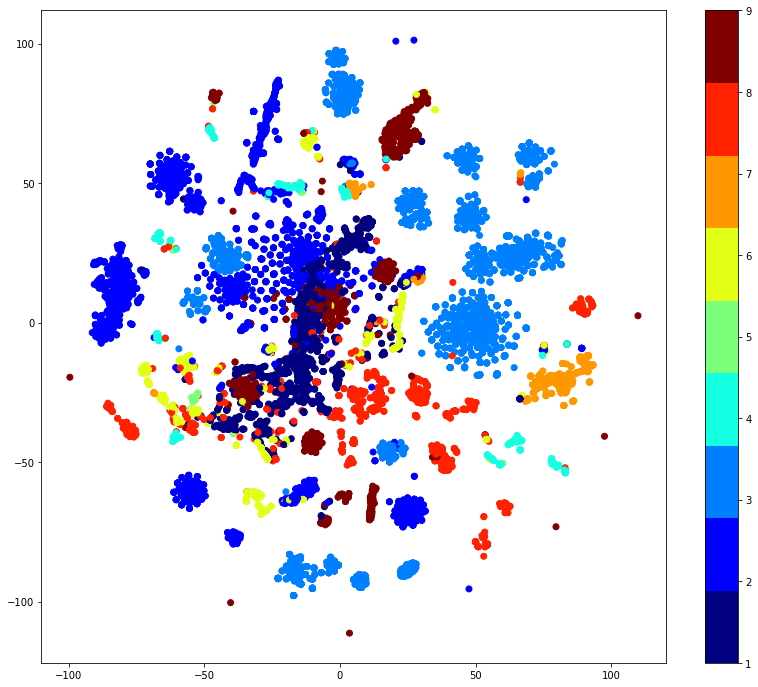

In [34]:
plt.figure(figsize=(14,12))

plt.scatter(tsne_fit[:,0], tsne_fit[:, 1], c = df_XY['class'], cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar()

## with perplexity 40

In [35]:
tsne = TSNE(perplexity=40)

tsne_fit = tsne.fit_transform(df_XY.drop(['Id', 'ID', 'class'], axis=1))

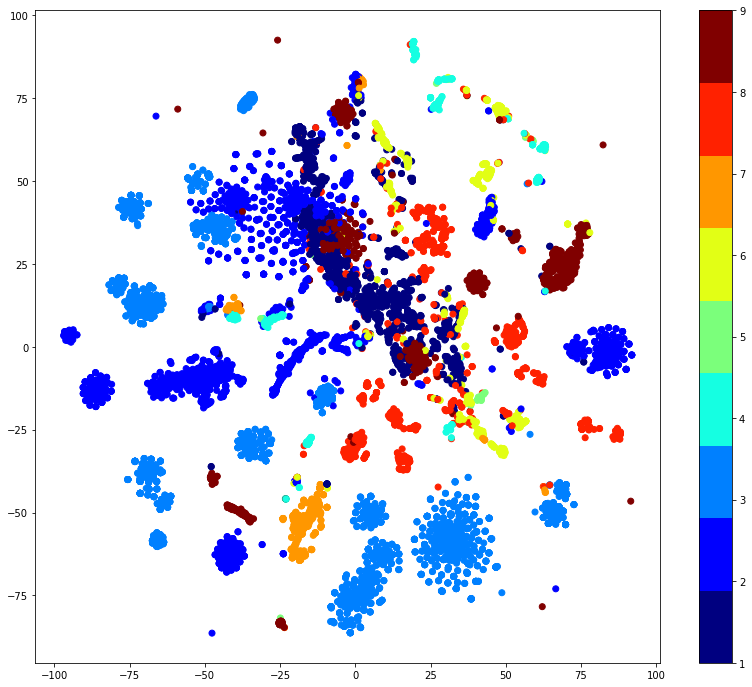

In [36]:
plt.figure(figsize=(14,12))

plt.scatter(tsne_fit[:,0], tsne_fit[:, 1], c = df_XY['class'], cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar()

Obtain the training + CV and test features as we did for bytefile features.

In [8]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(
    df_XY.drop(['Id', 'ID','class'], axis=1),
    df_XY['class'],
    test_size=.2)

Standardize data

In [9]:
scaler = StandardScaler()
scaler.fit(X_train_cv)

X_train_cv = scaler.transform(X_train_cv)
X_test = scaler.transform(X_test)

In [51]:
X_train_cv.shape, y_train_cv.shape

((8694, 308), (8694,))

## Model 5: Gradient Boosted Trees (bytefile + asmfile features)  

In [18]:
gbt = GradientBoostingClassifier()


parameters_dict = {'learning_rate': [.05, .1, .2], 'n_estimators' : [100, 150, 200]}

clf_gridsrch = GridSearchCV(gbt,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=True,
                            cv=4,
                           scoring='neg_log_loss',
                           )

In [ ]:
%%notify
clf_gridsrch.fit(X_train_cv,y_train_cv)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [20]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'learning_rate': 0.05, 'n_estimators': 150}
The best score during Training/CV was -0.03192926215753811
The score on Test data was -0.023318709107116694


In [21]:
X_train_cv.shape

(8694, 308)

In [29]:
table.add_row([model_number, 'Gradient Boosting Classifier', 'bytefiles & asmfiles', '308', '0.03','0.02'])
model_number+=1

## model 6: XGBoost on Bytefile + asm file features

In [10]:
from xgboost import XGBClassifier

In [20]:
xgb = XGBClassifier()

parameters_dict = {'max_depth': [3, 4], 'n_estimators' : [100,150,200], 'learning_rate': [.1, .2]}

clf_gridsrch = GridSearchCV(xgb, param_grid=parameters_dict,
                           n_jobs=-1, verbose=1, cv=4, scoring='neg_log_loss')

In [21]:
%%notify
clf_gridsrch.fit(X_train_cv, y_train_cv)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.4min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 4],
                         'n_estimators': [100, 150, 200]},
             pre_dispatch='2*n_jobs

<IPython.core.display.Javascript object>

In [22]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.2}
The best score during Training/CV was -0.017589505840977796
The score on Test data was -0.012673176273645295


In [30]:
table.add_row([model_number, 'XGBClassifier', 'bytefiles & asmfiles', '308', '0.018','0.013'])
model_number+=1

Number of misclassified points  0.41398344066237347
-------------------------------------------------- Confusion matrix --------------------------------------------------


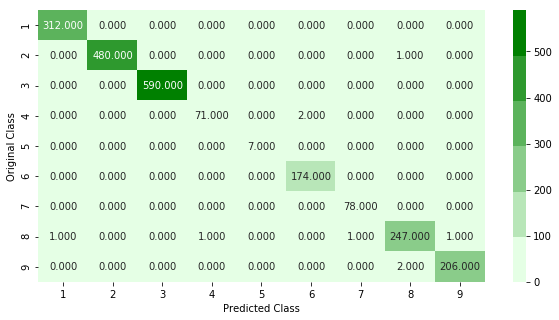

-------------------------------------------------- Precision matrix --------------------------------------------------


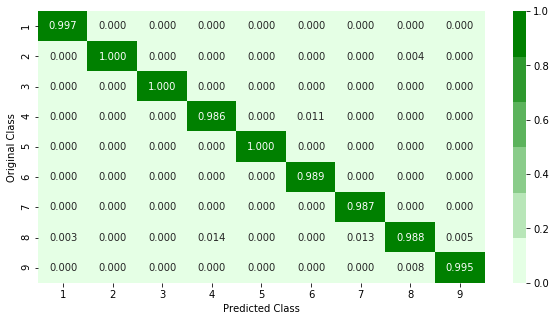

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


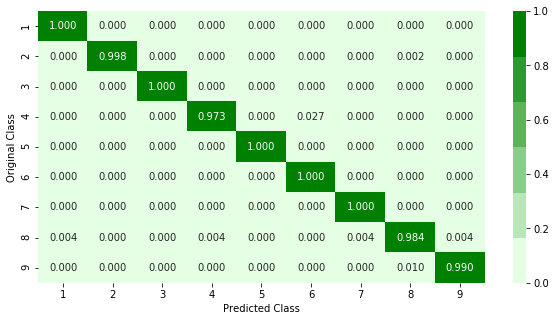

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
plot_confusion_matrix(y_test, clf_gridsrch.predict(X_test))

## Model 7: Logistic regression on ByteFile + asm file features

In [25]:
lr = LogisticRegression(penalty='l2', multi_class='auto', solver='lbfgs')

parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf_gridsrch = GridSearchCV(lr,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=1,
                            cv=5,
                           scoring='neg_log_loss')

In [26]:
%%notify
clf_gridsrch.fit(X_train_cv, y_train_cv)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   47.1s finished
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

<IPython.core.display.Javascript object>

In [27]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'C': 0.1}
The best score during Training/CV was -0.27120257863494895
The score on Test data was -0.22954718995465526


In [31]:
table.add_row([model_number, 'Logistic Regression', 'bytefiles & asmfiles', '308', '0.27','0.22'])
model_number+=1

Number of misclassified points  3.8178472861085555
-------------------------------------------------- Confusion matrix --------------------------------------------------


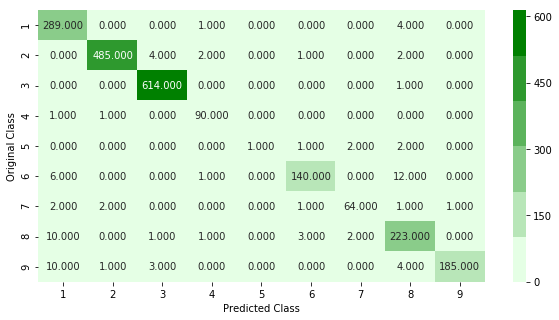

-------------------------------------------------- Precision matrix --------------------------------------------------


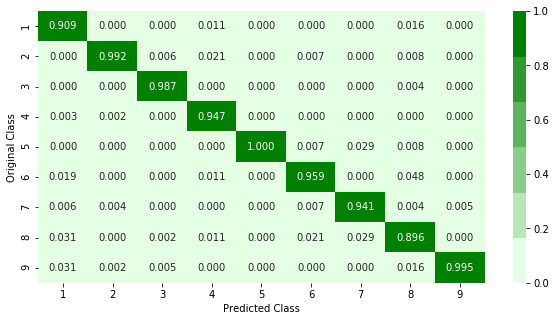

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


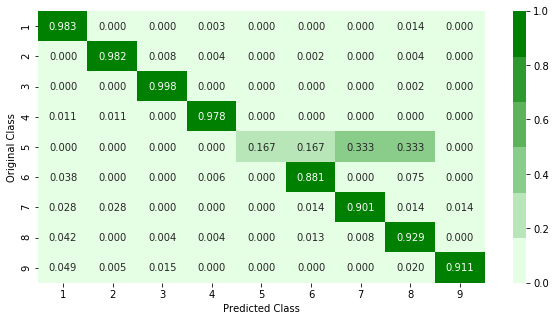

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [30]:
plot_confusion_matrix(y_test, clf_gridsrch.predict(X_test))

## Model 8: Random Forest (bytefile + asm file features)

In [61]:
rf = RandomForestClassifier()

parameters_dict = {'n_estimators': [100,150,200],
                  'max_depth': [15, 13, 11]}

clf_gridsrch = GridSearchCV(rf,
                            param_grid=parameters_dict,
                            n_jobs=-1,
                            verbose=0,
                            cv=5,
                           scoring='neg_log_loss')

In [62]:
clf_gridsrch.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [63]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'max_depth': 15, 'n_estimators': 200}
The best score during Training/CV was -0.06402767128581602
The score on Test data was -0.07016484462469132


In [32]:
table.add_row([model_number, 'Random Forests', 'bytefiles & asmfiles', '308', '0.06','0.07'])
model_number+=1

Number of misclassified points  0.9659613615455382
-------------------------------------------------- Confusion matrix --------------------------------------------------


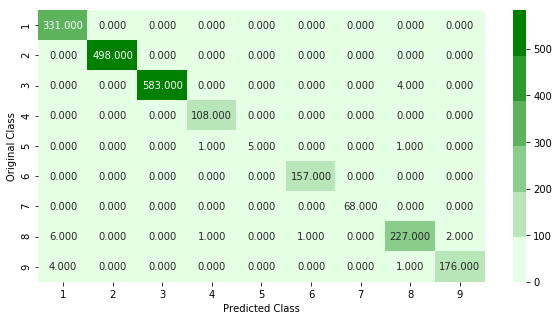

-------------------------------------------------- Precision matrix --------------------------------------------------


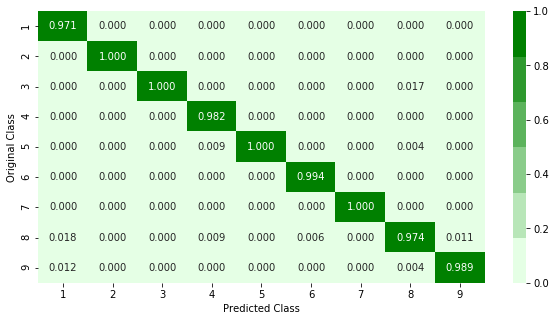

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


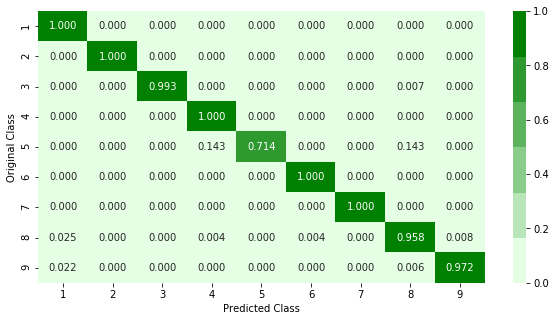

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [64]:
plot_confusion_matrix(y_test, clf_gridsrch.predict(X_test))

## Model 9: Multi-layered perceptron (bytefiles + asmfiles)

In [13]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          to_categorical(y_train-1, num_classes=9),
#          y_train,
          epochs=200,
          batch_size=4096,
        verbose=1)
#          validation_data=(x_val, y_val))

#results = model.evaluate(X_test, y_test)
results = model.evaluate(X_test, to_categorical(y_test-1, num_classes=9), verbose=1)

Epoch 1/200
8694/8694 [==============================] - 0s 44us/step - loss: 2.6016 - acc: 0.0222
Epoch 2/200
8694/8694 [==============================] - 0s 3us/step - loss: 2.1130 - acc: 0.1234
Epoch 3/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.8095 - acc: 0.5416
Epoch 4/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.5966 - acc: 0.6809
Epoch 5/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.4272 - acc: 0.7021
Epoch 6/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.2816 - acc: 0.6899
Epoch 7/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.1515 - acc: 0.6897
Epoch 8/200
8694/8694 [==============================] - 0s 3us/step - loss: 1.0375 - acc: 0.6922
Epoch 9/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.9452 - acc: 0.6984
Epoch 10/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.8730 - acc: 0.7097
Epoch 11/200
8694/

8694/8694 [==============================] - 0s 3us/step - loss: 0.0404 - acc: 0.9913
Epoch 166/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0384 - acc: 0.9925
Epoch 167/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0382 - acc: 0.9919
Epoch 168/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0373 - acc: 0.9924
Epoch 169/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0363 - acc: 0.9929
Epoch 170/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0366 - acc: 0.9928
Epoch 171/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0354 - acc: 0.9934
Epoch 172/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0354 - acc: 0.9931
Epoch 173/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0359 - acc: 0.9934
Epoch 174/200
8694/8694 [==============================] - 0s 3us/step - loss: 0.0356 - acc: 0.9944
Epoch 175/200


In [10]:
results

[0.09555776229962748, 0.9820607175712971]

In [33]:
table.add_row([model_number, 'Neural Network\n(128-64-32)', 'bytefiles & asmfiles', '308', '0.02','0.09'])
model_number+=1

In [12]:
np.argmax(model.predict(X_train)[431])

0

# Bag of words 2-gram representation

Similar to how we obtained a 1-gram Bag of words, we'll now get a 2-gram representation to train machine learning models on. Note that this means a huge increase in the number of features as well as the training time.

Load the dataframe which had text corpus of the byte files against each file ID.

In [3]:
df_bytefiles_textCorpus = pd.read_csv('df_bytefiles_textCorpus.csv',
                                      dtype={
                                          'Id': 'category',
                                          'Class': 'int',
                                          'bytefile_corpus': 'str'
                                      })

In [5]:
df_bytefiles_textCorpus.head()

,Id,Class,bytefile_corpus
0,01kcPWA9K2BOxQeS5Rju,1,6A FF 68 A3 16 00 10 64 A1 00 00 00 00 50 64 8...
1,04EjIdbPV5e1XroFOpiN,1,?? ?? ?? ?? 00 00 00 00 ?? ?? ?? ?? ?? ?? ?? ?...
2,05EeG39MTRrI6VY21DPd,1,56 8B F1 8B 46 04 85 C0 C7 06 A4 61 00 10 74 0...
3,05rJTUWYAKNegBk2wE8X,1,4D 5A 90 00 03 00 00 00 04 00 00 00 FF FF 00 0...
4,0AnoOZDNbPXIr2MRBSCJ,1,FF 25 F8 80 00 10 FF 25 F4 80 00 10 FF 25 D8 8...


Obtain the train, test sets

In [8]:
df_X_train, df_X_test, y_train, y_test = train_test_split(df_bytefiles_textCorpus.drop(
    ['Id', 'Class'], axis=1),
                                                    df_bytefiles_textCorpus['Class'],
                                                    test_size=0.1)

In [11]:
df_X_train.shape, df_X_test.shape, y_train.shape, y_test.shape

((9781, 1), (1087, 1), (9781,), (1087,))

In [12]:
df_X_train.head()

,bytefile_corpus
8473,57 6E 9E A7 A6 2D 4B 81 9B 74 4B BA 77 8A A6 8...
1379,8B 44 24 08 48 B8 01 00 00 00 C2 0C 00 55 8B E...
9920,B8 14 8C D9 2B 29 05 58 B2 40 00 C3 8B 0D 98 B...
5636,8D B3 BC 00 00 00 83 6D F8 C7 56 FF B6 38 01 0...
3308,C7 01 94 E3 40 00 E9 85 1F 00 00 CC CC CC CC C...


## Fit to the train data and get bigram features

In [ ]:
%%notify

vec = CountVectorizer(ngram_range=(1,2))

df_bow2gram_byte_transformed_train = vec.fit_transform(df_X_train.bytefile_corpus)

Type of vectorizer

In [16]:
type(vec)

sklearn.feature_extraction.text.CountVectorizer

**There are 65792 distinct bigram features**

In [18]:
len(np.unique(vec.get_feature_names()))

65792

In [17]:
np.unique(vec.get_feature_names())

array(['00', '00 00', '00 01', ..., 'ff fd', 'ff fe', 'ff ff'],
      dtype='<U5')

**Similarly, get bigram features of the test data**

In [19]:
%%notify

df_bow2gram_byte_transformed_test = vec.transform(df_X_test.bytefile_corpus)

<IPython.core.display.Javascript object>

In [20]:
type(df_bow2gram_byte_transformed_test)

scipy.sparse.csr.csr_matrix

Dump this transformed bigram vector on disk for future reference

In [9]:
import pickle
f = open('bow2gram_byte_transformed.pkl', 'wb')
pickle.dump(bow2gram_byte_transformed, f)
f.close()

Get a dataframe of bigram features along with the class associated with each file

In [21]:
# df_bytesfiles_bow2gram = pd.DataFrame(np.hstack([
#     pd.DataFrame(bow2gram_byte_transformed.toarray()),
#     df_bytefiles_textCorpus['Class'].values.reshape(-1, 1), df_bytefiles_textCorpus['Id'].astype('str').values.reshape(-1,1)
# ]),
#                                  columns=vec.get_feature_names() + ['class', 'Id'])

df_bytesfiles_bow2gram_train = pd.DataFrame(np.hstack([
    pd.DataFrame(df_bow2gram_byte_transformed_train.toarray()),
    y_train.values.reshape(-1, 1)
]),
                                 columns=vec.get_feature_names() + ['class'])


df_bytesfiles_bow2gram_test = pd.DataFrame(np.hstack([
    pd.DataFrame(df_bow2gram_byte_transformed_test.toarray()),
    y_test.values.reshape(-1, 1)
]),
                                 columns=vec.get_feature_names() + ['class'])


In [23]:
df_bytesfiles_bow2gram_train.shape

(9781, 65793)

In [24]:
df_bytesfiles_bow2gram_test.shape

(1087, 65793)

A sample of how the dataframe with bigram features looks

In [25]:
df_bytesfiles_bow2gram.head()

,00,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,ff f8,ff f9,ff fa,ff fb,ff fc,ff fd,ff fe,ff ff,class,Id
0,21091,10423,225,61,69,114,40,25,22,63,...,59,9,15,18,91,27,65,1363,1,01kcPWA9K2BOxQeS5Rju
1,40030,24468,357,201,200,109,55,35,185,78,...,8,2,2,0,5,1,6,3852,1,04EjIdbPV5e1XroFOpiN
2,19419,11188,201,79,128,82,47,16,35,46,...,9,1,3,2,8,3,5,526,1,05EeG39MTRrI6VY21DPd
3,79568,39861,604,335,154,281,66,68,749,408,...,25,3,5,2,14,15,18,15718,1,05rJTUWYAKNegBk2wE8X
4,25791,18601,256,79,76,162,39,19,45,35,...,9,8,0,7,43,2,19,2207,1,0AnoOZDNbPXIr2MRBSCJ


Dump the dataframes on to the disk for future use

In [25]:
df_bytesfiles_bow2gram_train.to_csv('df_bytesfiles_bow2gram_train.csv', index=False)
df_bytesfiles_bow2gram_test.to_csv('df_bytesfiles_bow2gram_test.csv', index=False)

In [6]:
#df_bytesfiles_bow2gram = pd.read_csv('df_bytesfiles_bow2gram.csv')

## Model 10: Multi Layered perceptron (2-gram bytefile features)

In [3]:
df_bytesfiles_bow2gram_train = pd.read_csv('df_bytesfiles_bow2gram_train.csv')
df_bytesfiles_bow2gram_test = pd.read_csv('df_bytesfiles_bow2gram_test.csv')

In [4]:
df_bytesfiles_bow2gram_train.head()

,00,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,ff f7,ff f8,ff f9,ff fa,ff fb,ff fc,ff fd,ff fe,ff ff,class
0,5968,4917,18,1,5,1,1,1,4,4,...,0,1,0,0,0,0,0,1,486,7
1,55154,35230,669,203,470,730,351,236,315,220,...,11,12,15,1,15,85,4,21,3550,1
2,92371,51171,234,127,234,147,170,140,191,179,...,1,0,0,2,2,2,1,0,267,9
3,11385,6318,40,26,77,26,52,16,36,22,...,9,10,13,14,13,4,9,9,175,3
4,152852,19022,2024,1340,1473,844,604,980,888,802,...,30,6,0,18,12,7,14,22,4012,2


In [5]:
df_bytesfiles_bow2gram_test.head()

,00,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,ff f7,ff f8,ff f9,ff fa,ff fb,ff fc,ff fd,ff fe,ff ff,class
0,7614,3443,29,21,46,16,34,15,28,19,...,8,19,13,9,10,5,6,14,66,3
1,64145,22827,961,295,246,407,189,217,315,247,...,5,0,126,162,252,378,2,463,8158,2
2,10141,5355,40,32,76,26,46,16,41,24,...,12,10,6,8,9,11,15,10,57,3
3,11551,6611,40,34,78,18,51,16,43,28,...,12,10,6,8,9,11,15,10,78,3
4,10612,9421,21,4,3,14,1,2,2,8,...,2,0,0,0,1,1,0,2,46,6


**Standardize the data**

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(df_bytesfiles_bow2gram_train.drop('class',axis=1).values)
X_test = scaler.transform(df_bytesfiles_bow2gram_test.drop('class', axis=1).values)

In [8]:
y_train = df_bytesfiles_bow2gram_train['class'].values
y_test = df_bytesfiles_bow2gram_test['class'].values

In [9]:
X_train.shape

(9781, 65792)

In [10]:
%%notify

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1], )))
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))


model.add(layers.Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          to_categorical(y_train-1, num_classes=9),
#          y_train,
          epochs=250,
          batch_size=512)
#          validation_data=(x_val, y_val))


results = model.evaluate(X_test, to_categorical(y_test-1, num_classes=9))

W0827 10:16:51.293953 139897748477696 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 10:16:51.486934 139897748477696 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 10:16:51.600531 139897748477696 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 10:16:51.660453 139897748477696 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0827 10:16:51.666584 

Epoch 1/250
9781/9781 [==============================] - 26s 3ms/step - loss: 3.0487 - acc: 0.4297
Epoch 2/250
9781/9781 [==============================] - 22s 2ms/step - loss: 1.5760 - acc: 0.6028
Epoch 3/250
9781/9781 [==============================] - 23s 2ms/step - loss: 1.1284 - acc: 0.7292
Epoch 4/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.8707 - acc: 0.7783
Epoch 5/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.7235 - acc: 0.8236
Epoch 6/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.6153 - acc: 0.8431
Epoch 7/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.4954 - acc: 0.8703
Epoch 8/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.4363 - acc: 0.8931
Epoch 9/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.3939 - acc: 0.9023
Epoch 10/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.3455 - acc: 0.9161
Epoch 11/

9781/9781 [==============================] - 23s 2ms/step - loss: 0.1577 - acc: 0.9547
Epoch 84/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.1053 - acc: 0.9724
Epoch 85/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0913 - acc: 0.9772
Epoch 86/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0943 - acc: 0.9787
Epoch 87/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.0711 - acc: 0.9839
Epoch 88/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.0671 - acc: 0.9844
Epoch 89/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.0856 - acc: 0.9798
Epoch 90/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0776 - acc: 0.9827
Epoch 91/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.1147 - acc: 0.9704
Epoch 92/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.1193 - acc: 0.9699
Epoch 93/250


9781/9781 [==============================] - 23s 2ms/step - loss: 0.0534 - acc: 0.9897
Epoch 246/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0539 - acc: 0.9879
Epoch 247/250
9781/9781 [==============================] - 23s 2ms/step - loss: 0.0561 - acc: 0.9874
Epoch 248/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0433 - acc: 0.9908
Epoch 249/250
9781/9781 [==============================] - 22s 2ms/step - loss: 0.0997 - acc: 0.9716
Epoch 250/250
1087/1087 [==============================] - 3s 2ms/step


<IPython.core.display.Javascript object>

In [26]:
results

[0.9467336988340457, 0.9034038639551143]

In [34]:
table.add_row([model_number, 'Neural Network\n(256-D/O-128-D/O-64-D/O-32)', 'bytefiles (2-gram)', '65792', '0.16','0.94'])
model_number+=1

In [28]:
model.predict(X_test)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [9.9854952e-01, 2.5977108e-06, 2.2720570e-09, ..., 2.6091840e-08,
        1.3496040e-03, 2.2872537e-05],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

## Model 11: Logistic Regression

In [15]:
lr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto')

parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf_gridsrch = GridSearchCV(lr,
                            param_grid=parameters_dict,
                            n_jobs=15,
                            verbose=False,
                            cv=3,
                           scoring='neg_log_loss',
                           )

In [16]:
%%notify

clf_gridsrch.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=15,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=False)

<IPython.core.display.Javascript object>

In [17]:
print('The best parameters were', clf_gridsrch.best_params_)
print('The best score during Training/CV was', clf_gridsrch.best_score_)
print('The score on Test data was', clf_gridsrch.score(X_test, y_test))

The best parameters were {'C': 0.01}
The best score during Training/CV was -0.19834097702046197
The score on Test data was -1.6645136402724219


In [35]:
table.add_row([model_number, 'Logistic Regression', 'bytefiles (2-gram)', '65792', '0.19','1.66'])
model_number+=1

Number of misclassified points  9.107635694572217
-------------------------------------------------- Confusion matrix --------------------------------------------------


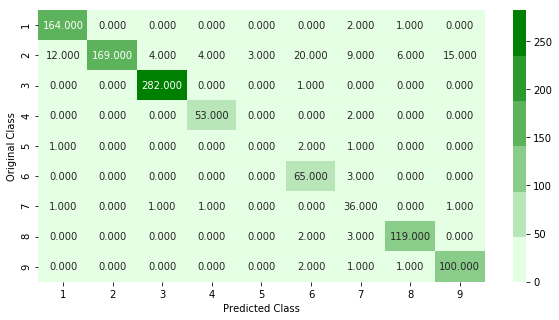

-------------------------------------------------- Precision matrix --------------------------------------------------


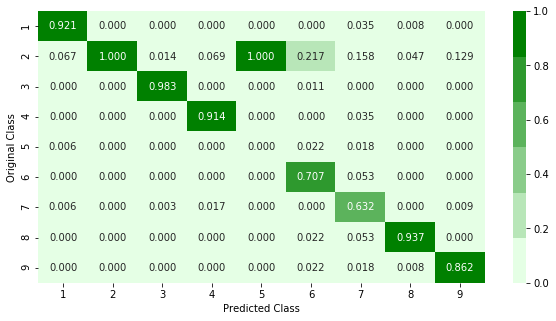

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


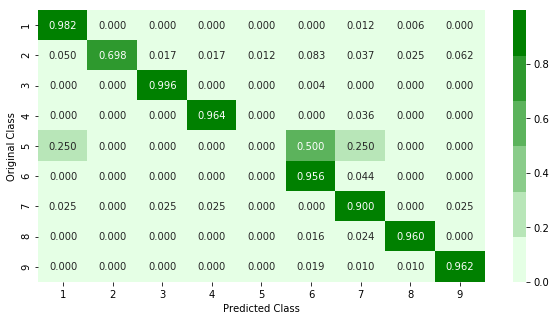

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [45]:
plot_confusion_matrix(y_test, clf_gridsrch.predict(X_test))

# Concluding remarks

* To solve the Mircrosoft Malware classification challenge, I tried out 11 ML models to classify the malwares into 9 different classes.
* The dataset I used had 10686 files each of type `.byte` and `.asm`, having a total size on disk of ~100GB.
* The best logloss score I could achieve was `0.013` using the **XGBClassifier** from the *XGBoost* library on combined Bag of Words features of .byte files and .asm files. Following is the complete summary of all the models I tried.

In [36]:
print(table)

+----+------------------------------+----------------------+-----------+---------------------+-----------------+
| #  |         ML algorithm         |       Features       | #Features | Log Loss (train/cv) | Log Loss (test) |
+----+------------------------------+----------------------+-----------+---------------------+-----------------+
| 1  |         Random Guess         |      bytefiles       |    257    |         2.48        |       2.50      |
| 2  |     Logistic Regression      |      bytefiles       |    257    |         0.59        |       0.67      |
| 3  |   Random Forest Classifier   |      bytefiles       |    257    |         0.45        |       0.42      |
| 4  | Gradient Boosting Classifier |      bytefiles       |    257    |         0.07        |       0.06      |
| 5  | Gradient Boosting Classifier | bytefiles & asmfiles |    308    |         0.03        |       0.02      |
| 6  |        XGBClassifier         | bytefiles & asmfiles |    308    |        0.018        |  